# Solutions for NUMA41, Assignment 3

## Artis Vijups

### Task 1

We import `numpy` and `matplotlib.pyplot` for use in this and following tasks. First, we introduce the data and `days_plot`, the $x$-coordinates at which to compute the energy and temperature.

In [1]:
from numpy import *
from matplotlib.pyplot import plot, show, legend, title, xticks

days = [-4,-3,-2,-1,0]
temp = [-1.9,-3.7,-5.77,2.53,4.32]
ener = [109.26,92.4,115.33,107.77,61.14]
days_plot = linspace(-4,0,1000)

Firstly, we interpolate using `polyfit` and `polyval`.

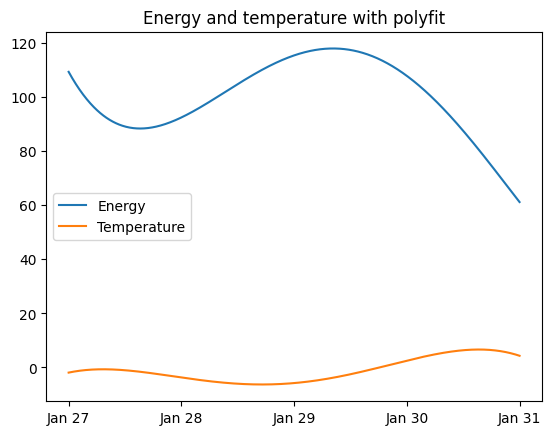

In [2]:
plot(days_plot, polyval(polyfit(days, ener, 4), days_plot), label="Energy")
plot(days_plot, polyval(polyfit(days, temp, 4), days_plot), label="Temperature")
title("Energy and temperature with polyfit")
legend()
xticks(days, ['Jan 27', 'Jan 28', 'Jan 29', 'Jan 30', 'Jan 31'])
show()

Secondly, we perform interpolation using Vandermonde's approach.

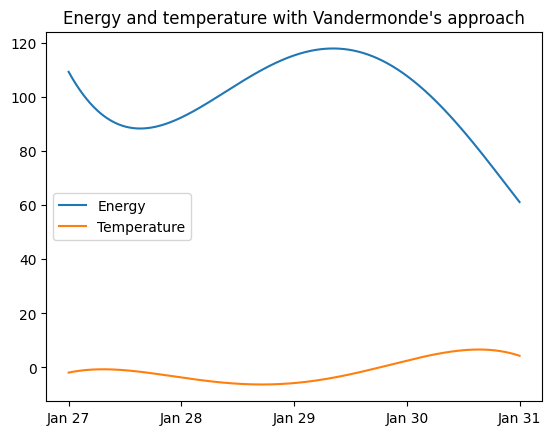

In [3]:
plot(days_plot, polyval(linalg.solve(vander(days), ener), days_plot), label="Energy")
plot(days_plot, polyval(linalg.solve(vander(days), temp), days_plot), label="Temperature")
title("Energy and temperature with Vandermonde's approach")
legend()
xticks(days, ['Jan 27', 'Jan 28', 'Jan 29', 'Jan 30', 'Jan 31'])
show()

Thirdly, we interpolate using Lagrange polynomials.

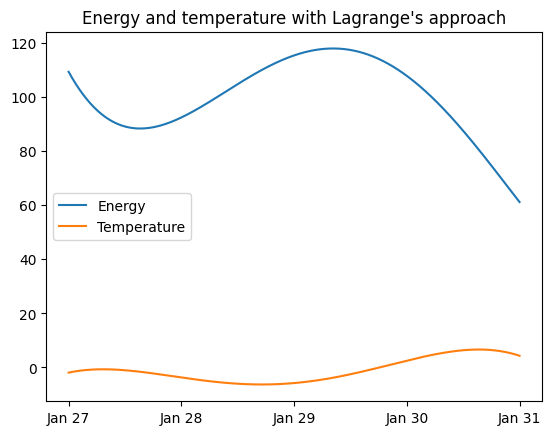

In [4]:
def lagrange(k,x):
    return lambda t: product([(t-x[i])/(x[k]-x[i]) for i in range(len(x)) if i != k])

def p(x,y):
    return lambda t: sum([y[k]*lagrange(k,x)(t) for k in range(len(x))])

plot(days_plot, [p(days,ener)(day) for day in days_plot], label="Energy")
plot(days_plot, [p(days,temp)(day) for day in days_plot], label="Temperature")
title("Energy and temperature with Lagrange's approach")
legend()
xticks(days, ['Jan 27', 'Jan 28', 'Jan 29', 'Jan 30', 'Jan 31'])
show()

The resulting polynomials are identical.

We then try to use the polynomials to extrapolate what the temperature and energy needs will be on February 8.

In [5]:
print(f"The temperature on February 8 will be {round(polyval(polyfit(days, temp, 4), 8),2)}°C.")
print(f"The energy needed on February 8 will be {round(polyval(polyfit(days, ener, 4), 8),2)} kWh.")

The temperature on February 8 will be -11322.92°C.
The energy needed on February 8 will be 17612.98 kWh.


As we can see, the results are very unrealistic. This suggests we usually should not use interpolated polynomials to make predictions outside the range of interpolated values.

### Tasks 2, 3

We introduce four separate approaches for how to choose the knots: a random selection of knots, equidistant knots, a manual selection of symmetric knots, and the Chebyshev points. For acquiring the Chebyshev points, we use `chebpts1` from `numpy.polynomial.chebyshev`.

It is particularly apparent in the $\omega_{15}(x)$ case that the Chebyshev points provide the lowest maximum error.

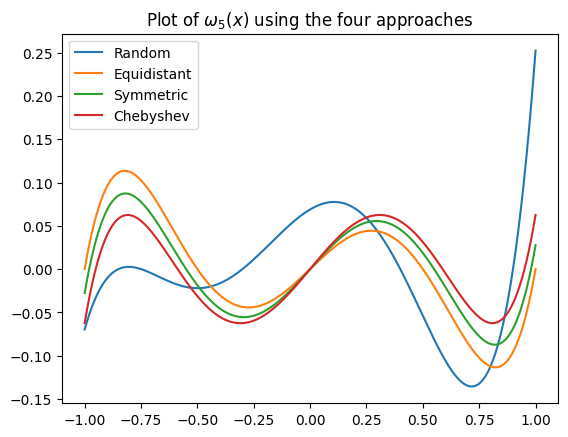

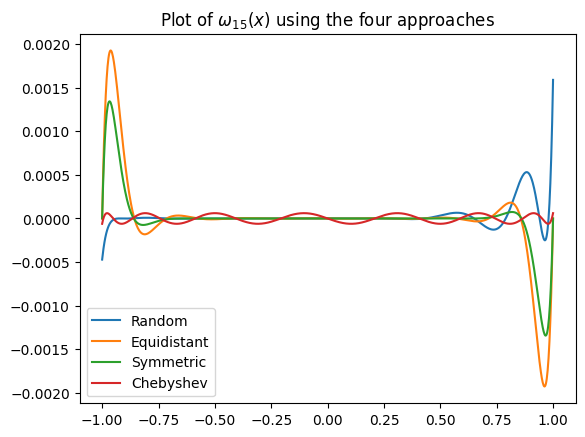

In [6]:
from numpy.polynomial.chebyshev import chebpts1 as cheb

def w(x, x_list):
    product = 1
    for xi in x_list:
        product *= x - xi
    return product

def draw(x_list, label=""):
    plot_x = linspace(-1,1,1001)
    plot_y = []
    for x in plot_x:
        plot_y.append(w(x, x_list))
    plot(plot_x, plot_y, label=label)
    #scatter(x_list, [0]*len(x_list))

draw([-0.85, -0.75, -0.3, 0.4, 0.9], label="Random")
draw([-1, -0.5, 0, 0.5, 1], label="Equidistant")
draw([-0.98, -0.55, 0, 0.55, 0.98], label="Symmetric")
draw(cheb(5), label="Chebyshev")
title(r"Plot of $\omega_5(x)$ using the four approaches")
legend()
show()
draw([-0.93,-0.91,-0.88,-0.71,-0.55,-0.54,-0.39,-0.21,-0.15,0.07,0.16,0.26,0.43,0.65,0.79,0.94,0.98], label="Random")
draw(linspace(-1,1,15), label="Equidistant")
draw([-1,-0.86,-0.65,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4,0.5,0.6,0.65,0.86,1], label="Symmetric")
draw(cheb(15), label="Chebyshev")
title(r"Plot of $\omega_{15}(x)$ using the four approaches")
legend()
show()

### Task 4

We interpolate the function $$f(x)=\frac{1}{1+25x^2}$$ on an equidistant grid and a Chebyshev point grid respectively.

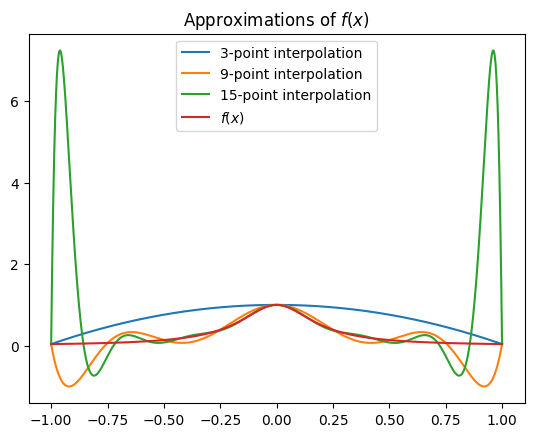

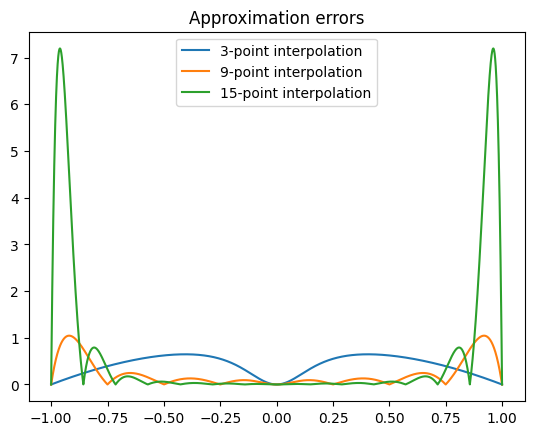

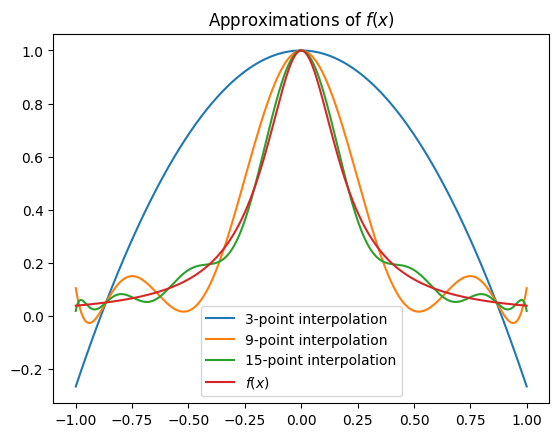

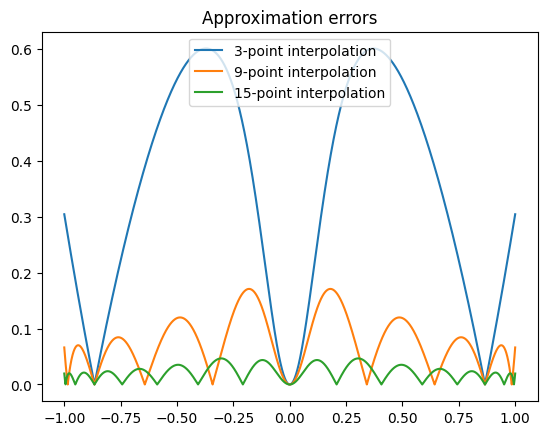

In [7]:
f = lambda x: 1 / (1+25*x*x)
x_list = linspace(-1,1,10001)

def interp(list):
    return polyfit(list, f(list), len(list)-1)

list1 = [interp(linspace(-1,1,3)), interp(linspace(-1,1,9)), interp(linspace(-1,1,15))]
list2 = [interp(cheb(3)), interp(cheb(9)), interp(cheb(15))]

for p_list in [list1, list2]:
    # interpolating polynomials
    for p in p_list:
        plot(x_list, polyval(p, x_list), label=str(len(p))+"-point interpolation")
    plot(x_list, f(x_list), label=r"$f(x)$")
    title(r"Approximations of $f(x)$")
    legend()
    show()
    # errors
    for p in p_list:
        plot(x_list, abs(f(x_list)-polyval(p,x_list)), label=str(len(p))+"-point interpolation")
    title("Approximation errors")
    legend(loc='upper center')
    show()

### Task 5

We create two functions. The first one, called `cubspline`, takes lists of observed $x$-values and the corresponding $y$-values, and creates the coefficient matrix for the cubic spline that interpolates the observations. The second one, called `cubsplineval`, evaluates a cubic spline at `xval`.

To acquire the $\sigma $-values needed to compute the coefficients, we use `dgtsv` from `scipy.linalg.lapack`.

In [8]:
from scipy.linalg.lapack import dgtsv

def cubspline(xint, yint):
    h = xint[1] - xint[0] # h is expected to be constant
    m = len(yint) # this is m+1 in the problem statement
    main_diag = [4]*(m-2)
    off_diag = [1]*(m-3)
    sigma = [0, *dgtsv(off_diag,main_diag,off_diag,6/h**2*diff(diff(yint)))[3], 0]
    coeff = empty((m-1,4))
    for i in range(m-1):
        coeff[i,:] = (sigma[i+1]-sigma[i])/(6*h), sigma[i]/2, (yint[i+1]-yint[i])/h-h*(2*sigma[i]+sigma[i+1])/6, yint[i]
    return coeff

def cubsplineval(coeff, xint, xval):
    n = 0
    while xint[n+1] < xval:
        n += 1
    return coeff[n,0]*(xval-xint[n])**3+coeff[n,1]*(xval-xint[n])**2+coeff[n,2]*(xval-xint[n])+coeff[n,3]

### Task 6

In this task, we describe the standard wheel profile S1002 as a cubic spline. We try different amounts of points to see how that affects the resulting graph and the error, both plotted with `plotly.express` for interactivity.

In [9]:
from s1002 import s1002 as y
import plotly.express as px

fig = px.scatter(title="Natural cubic spline representing the wheel profile")
fig2 = px.scatter(title="Error when comparing the spline to the wheel profile")

for m in [6,9,12,20,60,100,250,1000,1500,2500]: # number of points
    # getting the coefficients
    h = 130/m
    x_list = linspace(-70,60,m)
    y_list = [-y(x) for x in linspace(-70,60,m)]
    coeff = cubspline(x_list, y_list)
    # beginning to create the plot of the spline
    x_plot = []
    y_plot = []
    e_plot = []
    for x in linspace(-70,60,2601):
        x_plot.append(x)
        y_plot.append(cubsplineval(coeff, x_list, x))
        e_plot.append(abs(y_plot[-1]+y(x)))
    fig.add_scatter(x=x_plot, y=y_plot, name=f"{m} points")
    fig2.add_scatter(x=x_plot, y=e_plot, name=f"{m} points")
fig.add_scatter(x=x_plot, y=[-y(x) for x in x_plot], name=f"Original profile")
fig.show()
fig2.show()

### FAIR principles

**Findable:** the workflow is stored on a searchable platform (GitHub), identified as `bern02-workflow`, with provided keywords to improve searchability.

**Accessible:** the repository is publicly available, the platform uses HTTPS, and a clear license for reuse is provided.

**Interoperable:** standard file formats such as `.ipynb` are used. The environment dependencies are provided. One deficiency is that the tasks file is a `.pdf` file.

**Reusable:** the repository has a README, the notebook contains descriptions, with good formatting through LaTeX, and small comments.